# NHM Contrastive Learning Notebook
Marko Kadic, TU Wien

In this notebook I will apply contrastive learning, more specifically SimCLR to the Herbarium collection
of the Vienna Natural History Museum (NHM).

I will use it to classify the plants according to their genome and compare the results to the current state-of-the-art systems in the field on the: XY dataset.

I will also use the embeddings created by the contrastive learning to explore the phenotypical features of the plants, and to create a visual analysis tool for the botanical researchers.

The tool should help them explore their vast collection of plants.

**0. Installing Dependencies**

In [1]:
import sklearn
import scipy
import skimage
import pandas
import numpy as np
from PIL import Image
import bokeh
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

from tensorboard.plugins import projector

import cv2
import pathlib
import os
import datetime
#import tensorflow as tf

from os import listdir, walk
from os.path import isfile, join

from tensorboardX import SummaryWriter

/tmp/ipykernel_93525/2883140082.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
%pip install tensorboardX

/opt/sw/vsc4/modules/4.2.2/init/bash: line 37: /usr/bin/tclsh: No such file or directory
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**1. Dataset**
Data loading and Data preparation

/home/fs71186/kadic/notebooks
<class 'numpy.ndarray'>
(10098, 6740, 3)


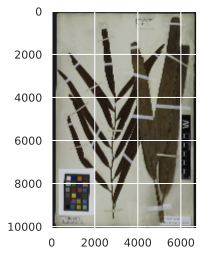

In [2]:
import cv2
import pathlib
print(pathlib.Path().resolve())

data_path_general = "/home/fs71186/kadic/data/jp2/"
data_path_1 = "/home/fs71186/kadic/data/jp2/141114/"
data_path_2 = "/home/fs71186/kadic/data/jp2/150120/"
data_path_3 = "/home/fs71186/kadic/data/jp2/150316/"
data_path_4 = "/home/fs71186/kadic/data/jp2/150423/"
data_path_5 = "/home/fs71186/kadic/data/jp2/161103/"

# Convert
img = cv2.imread(data_path_1 + "W0003101.jp2")
print(type(img))

print(img.shape)

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)
  
# display that image
plt.show()

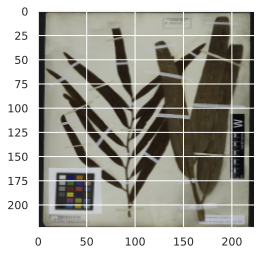

In [16]:
resized = cv2.resize(RGB_img, (224,224), interpolation=cv2.INTER_AREA)
plt.imshow(resized)
  
# display that image
plt.show()

In [3]:
from os import listdir, walk
from os.path import isfile, join
data_path_general = "../data/jp2/"
all_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_general) for f in filenames] 
print(all_image_files[0])
all_image_files.pop(0)
print(len(all_image_files))

../data/jp2/.DS_Store
1103


In [6]:
# get all images and store them in an array
#image_array = []
#for img_path in all_image_files:
#    img = cv2.imread(img_path)
#    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    resized = cv2.resize(RGB_img, (224,224), interpolation=cv2.INTER_AREA)
#    image_array.append(resized)

#print(image_array.shape)

**1.1. GPU, MACRO SETUP**

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = data_path_general
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/contrastive_models"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

[rank: 0] Global seed set to 42


Device: cuda:0
Number of workers: 256


In [6]:
class ImageDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    

    def __getitem__(self, index):
        image_path = self.paths[index]
        image_l = Image.open(image_path)
        image = image_l.convert('RGB')
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor


#dataset = ImageDataset(image_paths, transform)
    
#train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=1, shuffle=True)

**3. Contrastive Learning**

3.1. Augmenting the images

In [7]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [8]:

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [9]:

# Load dataset subset
dataset_sub = ImageDataset(all_image_files, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
#sub_train_loader = DataLoader(dataset_sub, batch_size = 100, num_workers = 1, shuffle = True)

#dataset_sub = SimpleImageDataset(sub_image_paths)

print(dataset_sub[0][0].shape)

torch.Size([3, 96, 96])


[rank: 0] Global seed set to 42


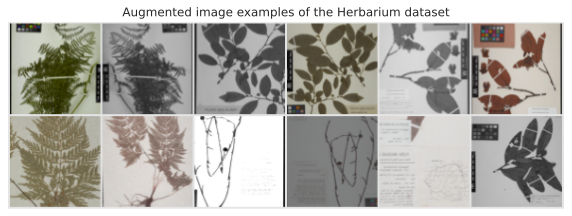

In [10]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in dataset_sub[idx]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Herbarium dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### 3.2. Contrastive Learning with SimCLR ###

In [10]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1,imgs2), dim=0)
        
        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    #def validation_step(self, batch, batch_idx):
    #    self.info_nce_loss(batch, mode='val')

Training

In [11]:
def train_simclr(batch_size, max_epochs=2, **kwargs):
    log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH +  "/SimCLR",
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = CHECKPOINT_PATH +  '/SimCLR.ckpt'
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = DataLoader(dataset_sub, batch_size = batch_size, shuffle = True, num_workers = NUM_WORKERS)
        
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader)
        trainer.save_checkpoint(pretrained_filename)
        
    return model

In [ ]:
# RUN THE TRAINING 
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fs71186/kadic/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[rank: 0] Global seed set to 42
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.h

## 4. Acquiring Feature Vectors from Model ##

In [26]:
!nvidia-smi

/opt/sw/vsc4/modules/4.2.2/init/bash: line 37: /usr/bin/tclsh: No such file or directory
Wed May 24 06:27:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:01:00.0 Off |                  Off |
| N/A   28C    P0    35W / 250W |   1764MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+

In [24]:
!pip3 install ipywidgets==7.7.5

/opt/sw/vsc4/modules/4.2.2/init/bash: line 37: /usr/bin/tclsh: No such file or directory
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)
    feats, imgs = [], []
    for batch_imgs1, batch_imgs2 in tqdm(data_loader):
        batch_imgs1 = batch_imgs1.to(device)
        batch_imgs2 = batch_imgs2.to(device)
        batch_feats1 = network(batch_imgs1)
        batch_feats2 = network(batch_imgs2)
        feats.append(batch_feats1.detach().cpu())
        feats.append(batch_feats2.detach().cpu())
        
    return feats

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, dataset_sub)

In [ ]:
print(train_feats_simclr[0].size())

In [ ]:
features_tensor = torch.cat(train_feats_simclr, 0)
print(features_tensor.size())
#torch.save(train_feats_simclr, "/Users/markokadic/Desktop/NII/saved_models/logs/tensor.tsv")

LOG_DIR = "/logs"

In [ ]:
images_vis = []
images_vis_ts =[]
transform = transforms.ToPILImage()

for btch1, btch2 in DataLoader(dataset_sub, batch_size=64, shuffle=False, drop_last=False):
    # convert the tensor to PIL image using above transform
    for i in range(0,len(btch1)):
        images_vis.append(transform(btch1[i]))
        images_vis.append(transform(btch2[i]))
        images_vis_ts.append(btch1[i])
        images_vis_ts.append(btch2[i])
        
print(len(images_vis))

## 5. Vector Embedding Visualisations ##

In [ ]:

class DeepFeatures(torch.nn.Module):
    '''
    Args:
        embs: image embeddings
        images: images to display
        imgs_folder (str): The folder path where the input data elements should be written to
        embs_folder (str): The folder path where the output embeddings should be written to
        tensorboard_folder (str): The folder path where the resulting Tensorboard log should be written to
        experiment_name (str): The name of the experiment to use as the log name
    '''
    

    def __init__(self, embs,
                 images,
                 imgs_folder,
                 embs_folder, 
                 tensorboard_folder,
                 experiment_name=None):
        
        super(DeepFeatures, self).__init__()
        
        self.embs = embs
        self.images = images
        self.imgs_folder = imgs_folder
        self.embs_folder = embs_folder
        self.tensorboard_folder = tensorboard_folder
        
        self.name = experiment_name
        
        self.writer = None
        
    
    def write_embeddings(self, outsize=(28,28)):
        '''
        Generate embeddings for an input batched tensor and write inputs and 
        embeddings to self.imgs_folder and self.embs_folder respectively. 
        
        Inputs and outputs will be stored in .npy format with randomly generated
        matching filenames for retrieval
        
        Args:
            x (torch.Tensor) : An input batched tensor that can be consumed by self.model
            outsize (tuple(int, int)) : A tuple indicating the size that input data arrays should be
            written out to
            
        Returns: 
            (bool) : True if writing was succesful
        
        '''
        
        assert len(os.listdir(self.imgs_folder))==0, "Images folder must be empty"
        assert len(os.listdir(self.embs_folder))==0, "Embeddings folder must be empty"
        
        # Detach from graph
        embs = self.embs.numpy()
            
        # Start writing to output folders
        for i in range(len(embs)):
            key = str(np.random.random())[-7:]
            np.save(self.imgs_folder + r"/" + key + '.npy', tensor2np(self.images[i], outsize))
            np.save(self.embs_folder + r"/" + key + '.npy', embs[i])
        return(True)
    
    
    def _create_writer(self, name):
        '''
        Create a TensorboardX writer object given an experiment name and assigns it to self.writer
        
        Args:
            name (str): Optional, an experiment name for the writer, defaults to self.name
        
        Returns:
            (bool): True if writer was created succesfully
        
        '''
        
        if self.name is None:
            name = 'Experiment_' + str(np.random.random())
        else:
            name = self.name
        
        dir_name = os.path.join(self.tensorboard_folder, 
                                name)
        
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        
        else:
            print("Warning: logfile already exists")
            print("logging directory: " + str(dir_name))
        
        logdir = dir_name
        self.writer = SummaryWriter(logdir=logdir)
        return(True)

    
    
    def create_tensorboard_log(self):
        
        '''
        Write all images and embeddings from imgs_folder and embs_folder into a tensorboard log
        '''
        
        if self.writer is None:
            self._create_writer(self.name)
        
        
        ## Read in
        all_embeddings = [np.load(os.path.join(self.embs_folder, p)) for p in os.listdir(self.embs_folder) if p.endswith('.npy')]
        all_images = [np.load(os.path.join(self.imgs_folder, p)) for p in os.listdir(self.imgs_folder) if p.endswith('.npy')]
        all_images = [np.moveaxis(a, 2, 0) for a in all_images] # (HWC) -> (CHW)

        ## Stack into tensors
        all_embeddings = torch.Tensor(all_embeddings)
        all_images = torch.Tensor(all_images)

        print(all_embeddings.shape)
        print(all_images.shape)

        self.writer.add_embedding(all_embeddings, label_img = all_images)

        

def tensor2np(tensor, resize_to=None):
    '''
    Convert an image tensor to a numpy image array and resize
    
    Args:
        tensor (torch.Tensor): The input tensor that should be converted
        resize_to (tuple(int, int)): The desired output size of the array
        
    Returns:
        (np.ndarray): The input tensor converted to a channel last resized array
    '''
    #print(tensor.size())
    out_array = tensor.detach().cpu().numpy()
    out_array = np.moveaxis(out_array, 0, 2) # (CHW) -> (HWC)
    
    if resize_to is not None:
        out_array = cv2.resize(out_array, dsize=resize_to, interpolation=cv2.INTER_CUBIC)
    
    return(out_array)

In [ ]:
IMGS_FOLDER = './imgs'
EMBS_FOLDER = './embs'
TB_FOLDER = './logs'
EXPERIMENT_NAME = 'contrast'
DEVICE = 'cpu'

In [ ]:
images_vec = images_vis_ts
embs_vec = features_tensor

print(images_vec[0].size())

DF = DeepFeatures(embs = embs_vec,
                  images  = images_vec,
                  imgs_folder = IMGS_FOLDER, 
                  embs_folder = EMBS_FOLDER, 
                  tensorboard_folder = TB_FOLDER, 
                  experiment_name=EXPERIMENT_NAME)

DF.write_embeddings()

DF.create_tensorboard_log()

In [ ]:
#!kill 16891
%tensorboard --logdir=logs